In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Data Exploration

The goal of this module is to give a practical overview of the techniques used during data exploration. You will learn how to build intuitions and gain confidence with a previously unknown dataset.

## Table of Contents

1. [Loading the dataset](#Loading-the-dataset)
2. [First look at the dataset](#First-look-at-the-dataset)
2. [Missing values](#Missing-values)
4. [Exploratory data analysis](#Exploratory-data-analysis)
    1. [Numerical variables](#Numerical-variables)
    2. [Categorical variables](#Categorical-variables)
5. [Conclusion](#Conclusion)



## Loading the dataset

In this notebook we are going to analyse the **Adult dataset**, which is a widely used example in the data science community. The dataset is available to download as from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) or [OpenML](http://openml.org/):
* https://archive.ics.uci.edu/ml/datasets/Adult,
* http://www.openml.org/d/1590

Luckily for us, the `sklearn.datasets` package is able to download datasets directly from the OpenML repository

<div class="alert alert-block alert-info">
If you prefer the hard way, feel free to download the data with one of the previous links. You will see that though the files have comma-separated values, they will require a little manual work or a bit of googling to be read with the correct headers.
</div>

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml

df, target = fetch_openml(
    data_id=1590,  # OpenML ID of the dataset
    return_X_y=True,  # return a tuple (data, target)
    as_frame=True,  # return Pandas (dataframe, series)
)

# add the target as a column (for simplicity)
# and remove possible duplicates
df = pd.concat([df, target], axis=1).drop_duplicates()
target_column = "class"

## First look at the dataset

As one can read from the [UCI description](https://archive.ics.uci.edu/ml/datasets/Adult), the **adult** dataset is an extraction from the 1994 Census database and the task is is to predict whether a given adult makes more than
$50,000 a year based on attributes such as education, hours of work per week, etc.

First of all, let's take a look at the target variable.

In [3]:
df["class"].head()

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

In [4]:
df["class"].value_counts()

<=50K    37109
>50K     11681
Name: class, dtype: int64

In [5]:
# Can you obtain the relative frequencies of the two classes?

# Write here your code!


We have a binary classification problem, where the two classes are `<=50K` and `>50K`.

<div class="alert alert-block alert-warning">
Notice that there are more samples of one class compared to the other. <b>Class imbalance</b> is very frequent in real world datasets and usually makes machine learning more difficult.
    
For example, models tend to underperform on rare classes. This can be a serious issue in healthcare: if one tries to predict if a subject will develop an illness , what will a model learn if it is trained on a dataset where healthy subjects are overrepresented with respect to ill subjects?
</div>

Let's now take a look at the rest of the dataset

In [6]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48790 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48790 non-null  float64 
 1   workclass       45995 non-null  category
 2   fnlwgt          48790 non-null  float64 
 3   education       48790 non-null  category
 4   education-num   48790 non-null  float64 
 5   marital-status  48790 non-null  category
 6   occupation      45985 non-null  category
 7   relationship    48790 non-null  category
 8   race            48790 non-null  category
 9   sex             48790 non-null  category
 10  capital-gain    48790 non-null  float64 
 11  capital-loss    48790 non-null  float64 
 12  hours-per-week  48790 non-null  float64 
 13  native-country  47934 non-null  category
 14  class           48790 non-null  category
dtypes: category(9), float64(6)
memory usage: 3.0 MB


In [8]:
df.shape

(48790, 15)

Every row in the dataset represents a person described by age, education, occupation, etc, that will be used as features for the subsequent classification task.

There are both numerical columns and categorical variables. Their meaning is straightforward, except for **fnlwgt**. It is not completely clear from the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names), but that seems to be a "weight" assigned by the [US Census Bureau](https://www.census.gov/programs-surveys/cps/technical-documentation/methodology/weighting.html) (CPS), based on the inverse probability of selection of the person in the sample plus adjustments due to the complex sampling design of the CPS. The only important point for us here is that **this variable does not convey useful information for our classification task** and we are going to remove it.

<div class="alert alert-block alert-success">
When we approach a machine learning problem with a real-world dataset, we should always make sure to get the meaning of all variables and try to understand if they provide useful or "right" information for our task. Other examples could be:
    
* ids or variables that are unique for each sample,
* dates.
</div>

## Missing values

Some records in the dataset contains missing values. The dataframe `info` method already showed that, but let's make it more clear counting their number:

In [9]:
df.isnull().sum()

age                  0
workclass         2795
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     856
class                0
dtype: int64

In [10]:
# Can you obtain relative frequencies?

# Write your code here!


We found missing values in `workclass`, `occupation` and `native-country`. For the moment, it's enough to know acknowledge their presence, but we will see that they need to be dealt in some way with before model training. Indeed most machine learning algorithms do not work with null values and specific techniques need to be used to remove them.

<div class="alert alert-block alert-info">

Real world datasets can be very messy and have loads of missing values. But python always has interesting tools to help us. For example, the package <b><a href=https://github.com/ResidentMario/missingno>missingno</a></b> can be very handy to have visual understanding of data completeness or quickly spot possible patterns of missing values.
    
</div>

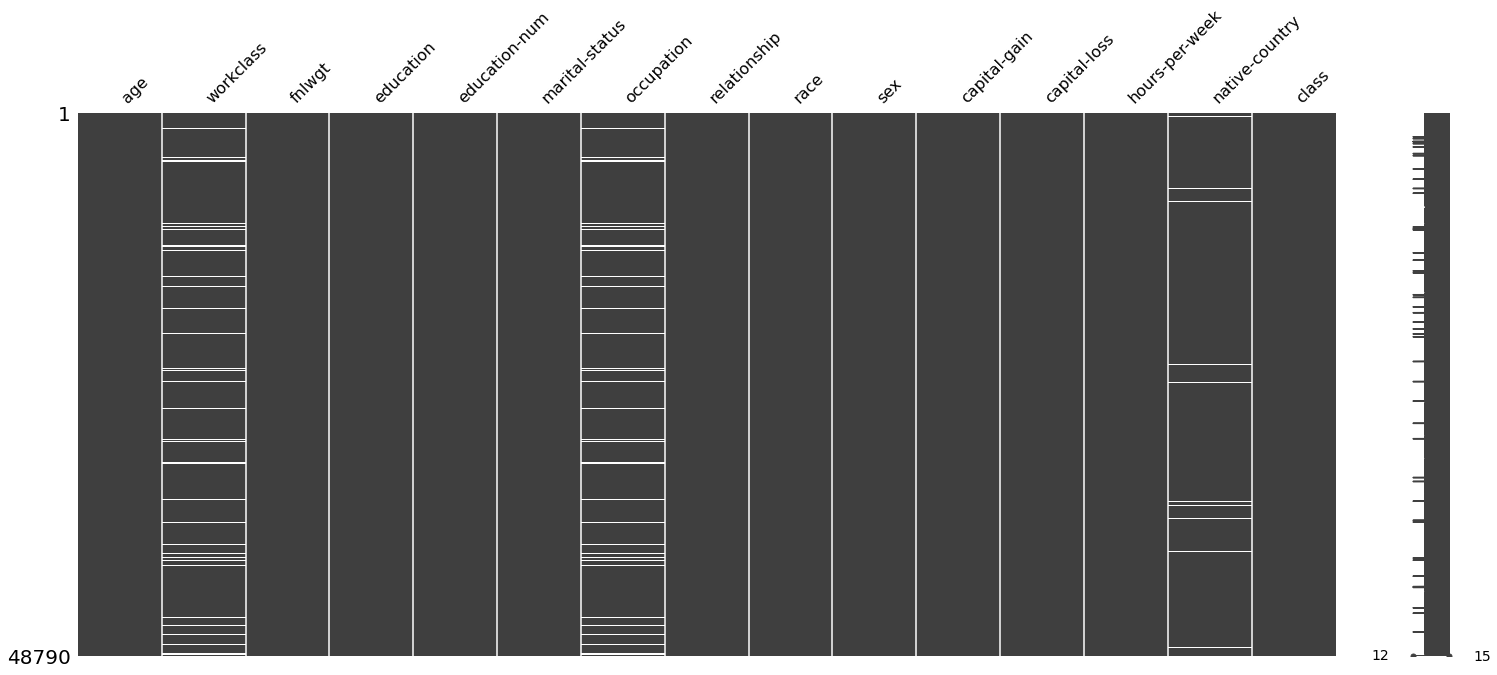

In [11]:
import missingno

missingno.matrix(df)

## Exploratory data analysis

Now we are going to dive deeper into each feature in the dataset, trying to understand what values they assume, how they are distributed and if there are anomalies, outliers or interesting correlations. We will do lots of plot and visual inspection of the data, both for numerical and categorical columns.

### Numerical variables

In [12]:
numerical_columns = df.drop(columns=["fnlwgt"]).select_dtypes([int, float]).columns.tolist()
numerical_columns

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [13]:
df[numerical_columns].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

,age,education-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,10.078807,1080.217688,87.595573,40.425886
std,13.708493,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
90%,58.000000,13.000000,0.000000,0.000000,55.000000
99%,74.000000,16.000000,15024.000000,2001.000000,80.000000
99.9%,90.000000,16.000000,99999.000000,2559.000000,99.000000


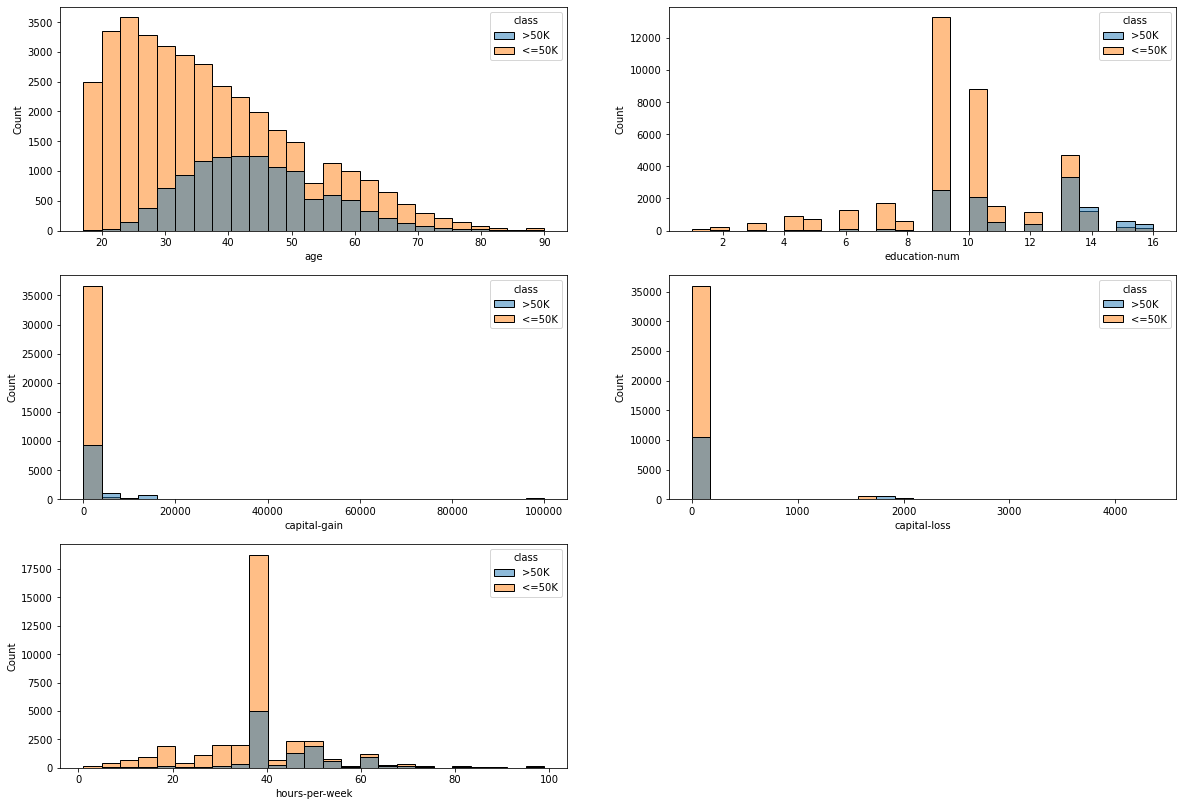

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a composite plot, with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,14))
# we have 5 variables to plot, so remove the 6th unused one
fig.delaxes(axes[2, 1])

# axes is a list of lists
# better to flatten it so that we can easily loop over it
axes = [y for x in axes for y in x]

for column, ax in zip(numerical_columns, axes):
    sns.histplot(data=df, x=column, ax=ax, hue="class", bins=25)

A few simple observations:
* `hours-per-week` is striclty greater than zero. It peaks around 40, that is likely to be the standard when the data was collected.
* Most of the people have `age` between 20 and 70, with a minimum age of 17.
* `capital-gain` and `capital-loss` are mostly equal to zero, but have a few very large outliers.

<div class="alert alert-block alert-warning">

Do not underestimate the importance of this kind of <b>sanity checks</b>!
    
</div>

More interestingly, plotting histograms conditioned on our target variable we notice that high income individuals seems to have:
* higher `age`,
* higher `education-num`,
* higher `hours-per-week`.

In other words, we observe a form of **correlation** between variables and target.

Looking at correlations between variables we find instead no significant correlation (remember that pandas `corr` uses [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) by default).

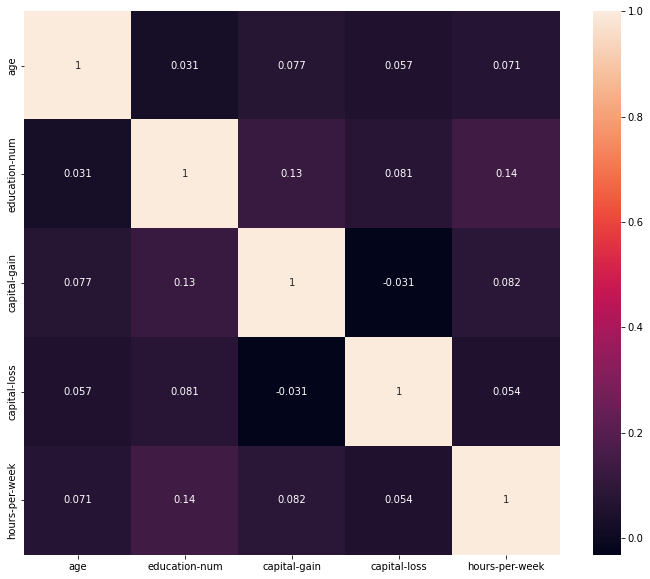

In [15]:
plt.subplots(figsize=(12,10))
_ = sns.heatmap(df[numerical_columns].corr(), annot=True)

### Categorical variables

In [16]:
categorical_columns = df.drop(columns=target_column).select_dtypes("category").columns.tolist()
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

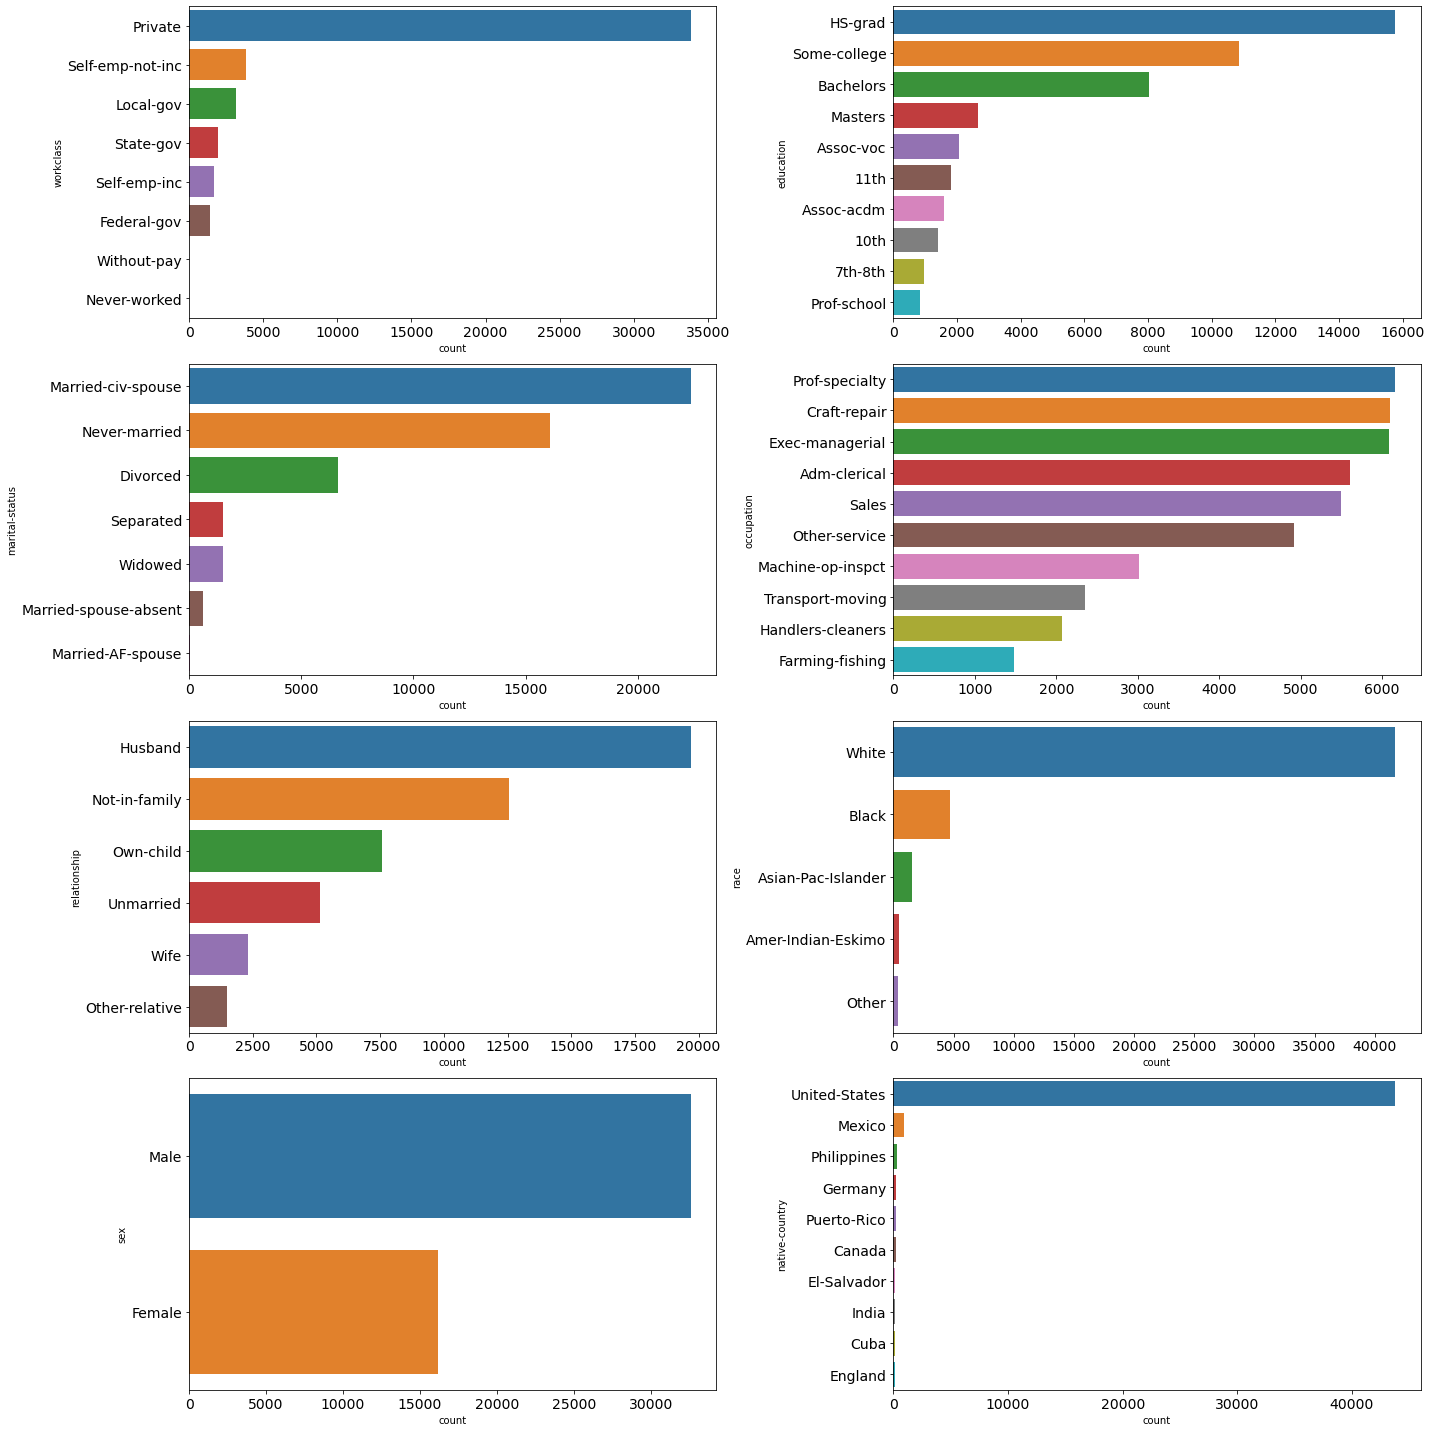

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
axes = [y for x in axes for y in x]

for column, ax in zip(categorical_columns, axes):
    sns.countplot(
        data=df, y=column,
        order=df[column].value_counts()[:10].index,  # plot the first 10 classes, sorted by count
        ax=ax)
    ax.tick_params(labelsize=14)
plt.tight_layout()

There are important observations to make here. The variables `sex`, `race` and `native-country` show significant imbalance in class distribution. This impacts the generalization power of any conclusions that we may draw on US population from this exploration and, even more importantly, can lead to [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) problems for our machine learning model. For example, for the `sex` variable, we can see that there is strong disparity in the income distribution:

In [18]:
disparity_df = pd.DataFrame(df.groupby(["sex"])["class"].value_counts(normalize=True)*100).round(2).reset_index()
disparity_df.columns = ["sex", "income", "count"]
disparity_df

,sex,income,count
0,Female,<=50K,89.06
1,Female,>50K,10.94
2,Male,<=50K,69.61
3,Male,>50K,30.39


As you can see, the group with `sex==Male` is privileged with respect to the group with `sex==Female`, having a probability of `income>50K` three times higher than the other group.

<div class="alert alert-block alert-warning">

This may have tangible consequences! Imagine you want to use a model trained on this dataset to choose if a person is eligible for a loan or not. If you not pay attention to this <b>bias in the dataset</b>, it is very likely the model too will be negatively biased towards women. Making a decision using predictions from such a model would be clearly unfair and highly problematic.
    
</div>

Finally, we notice that `education-num` and `education` have the same information, one being the continuos representation of the other. The following table makes this relationship clear.

When training the model, we will remove one of the two.

In [19]:
pd.crosstab(index=df["education"], columns=df["education-num"])

education-num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
education,,,,,,,,,,,,,,,,
Bachelors,0,0,0,0,0,0,0,0,0,0,0,0,8013,0,0,0
Some-college,0,0,0,0,0,0,0,0,0,10863,0,0,0,0,0,0
11th,0,0,0,0,0,0,1812,0,0,0,0,0,0,0,0,0
HS-grad,0,0,0,0,0,0,0,0,15770,0,0,0,0,0,0,0
Prof-school,0,0,0,0,0,0,0,0,0,0,0,0,0,0,834,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1601,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,2060,0,0,0,0,0
9th,0,0,0,0,756,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,954,0,0,0,0,0,0,0,0,0,0,0,0


## Conclusion

In this notebook we have learned about data exploration, using the Adult dataset. After a first look at the dataset, we discussed:
* missing values,
* numerical variables,
* categorical variables.

Some of the observations we made here will be used in the data preprocessing we are going to do before model training, for example how to deal with missing values.

-----------------------

Now, time for [quiz](https://forms.gle/oEx6VPyFxdCdK4hv5)!

*Some questions will require a couple of lines of code, feel free to write them after this cell.*